In [22]:
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [23]:
# 1. Load CSV files
labeled = pd.read_csv('../data/processed/labeled_subset.csv')
iso_df = pd.read_csv('../data/processed/with_isolation_forest.csv')
ae_df = pd.read_csv('../data/processed/with_autoencoder_tuned.csv')

In [30]:
# 2. Convert timestamps
for df in [labeled, iso_df, ae_df]:
    df['timestamp'] = pd.to_datetime(df['timestamp'])

In [31]:
# 3. Check available columns before merge
print("✅ labeled.columns:", labeled.columns.tolist())
print("✅ iso_df.columns:", iso_df.columns.tolist())
print("✅ ae_df.columns:", ae_df.columns.tolist())

✅ labeled.columns: ['timestamp', 'url', 'is_anomaly_if', 'is_anomaly_ae', 'is_anomaly_label']
✅ iso_df.columns: ['ip', 'timestamp', 'method', 'url', 'status', 'bytes', 'referrer', 'user_agent', 'hour', 'day', 'weekday', 'url_length', 'anomaly_score', 'is_anomaly_if']
✅ ae_df.columns: ['timestamp', 'url', 'is_anomaly_if_x', 'is_anomaly_ae_x', 'is_anomaly_label', 'ip', 'method', 'status', 'bytes', 'referrer', 'user_agent', 'hour', 'day', 'weekday', 'url_length', 'anomaly_score', 'is_anomaly_if_y', 'recon_error', 'is_anomaly_ae_y', 'ae_pred_optimized']


In [32]:
# 4. Merge predictions into labeled set
merged_df = labeled.merge(
    iso_df[['timestamp', 'url', 'is_anomaly_if']],  # predicted IF
    on=['timestamp', 'url'],
    how='left'
).merge(
    ae_df[['timestamp', 'url', 'ae_pred_optimized']],  # predicted AE
    on=['timestamp', 'url'],
    how='left'
)

In [33]:
# 5. Rename columns for clarity
merged_df.rename(columns={
    'is_anomaly_if': 'pred_if',
    'ae_pred_optimized': 'pred_ae',
}, inplace=True)

In [34]:
# 6. Assign ground truth labels from labeled file
# Check for truth labels in labeled
if 'is_anomaly_if' in labeled.columns:
    merged_df['true_if'] = labeled['is_anomaly_if']
else:
    print("⚠️ 'is_anomaly_if' not found in labeled dataset!")

if 'is_anomaly_ae' in labeled.columns:
    merged_df['true_ae'] = labeled['is_anomaly_ae']
else:
    print("⚠️ 'is_anomaly_ae' not found in labeled dataset!")

In [35]:
# 7. Now drop missing values safely
required_cols = ['true_if', 'true_ae', 'pred_if', 'pred_ae']
present_cols = [col for col in required_cols if col in merged_df.columns]
print("✅ Columns available for dropna:", present_cols)

✅ Columns available for dropna: ['true_if', 'true_ae', 'pred_ae']


In [36]:
merged_df = merged_df.dropna(subset=present_cols)

In [37]:
# 8. Cast to int
merged_df[present_cols] = merged_df[present_cols].astype(int)

In [38]:
# 9. Evaluation function
def evaluate(true, pred, name):
    print(f"📊 {name}")
    print("Precision:", precision_score(true, pred))
    print("Recall   :", recall_score(true, pred))
    print("F1 Score :", f1_score(true, pred))
    print()

In [39]:
# 10. Evaluate if columns exist
if 'true_if' in merged_df.columns and 'pred_if' in merged_df.columns:
    evaluate(merged_df['true_if'], merged_df['pred_if'], 'Isolation Forest')

if 'true_ae' in merged_df.columns and 'pred_ae' in merged_df.columns:
    evaluate(merged_df['true_ae'], merged_df['pred_ae'], 'Autoencoder')

📊 Autoencoder
Precision: 0.9
Recall   : 0.972972972972973
F1 Score : 0.935064935064935



In [40]:
# 11. Confusion matrix
def plot_cm(true, pred, title):
    cm = confusion_matrix(true, pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f'{title} - Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

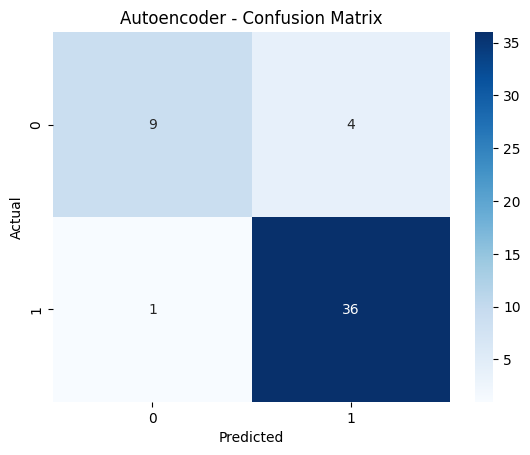

In [41]:
if 'true_if' in merged_df.columns and 'pred_if' in merged_df.columns:
    plot_cm(merged_df['true_if'], merged_df['pred_if'], 'Isolation Forest')

if 'true_ae' in merged_df.columns and 'pred_ae' in merged_df.columns:
    plot_cm(merged_df['true_ae'], merged_df['pred_ae'], 'Autoencoder')

## Plotting Precision-Recall (PR) and ROC Curves

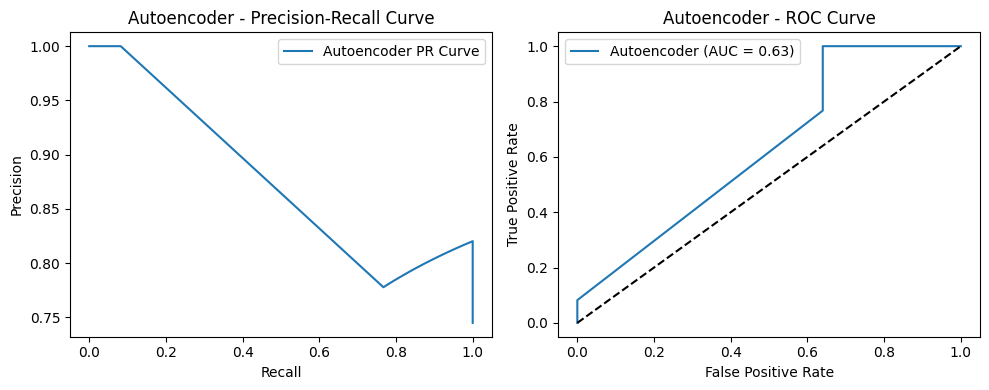

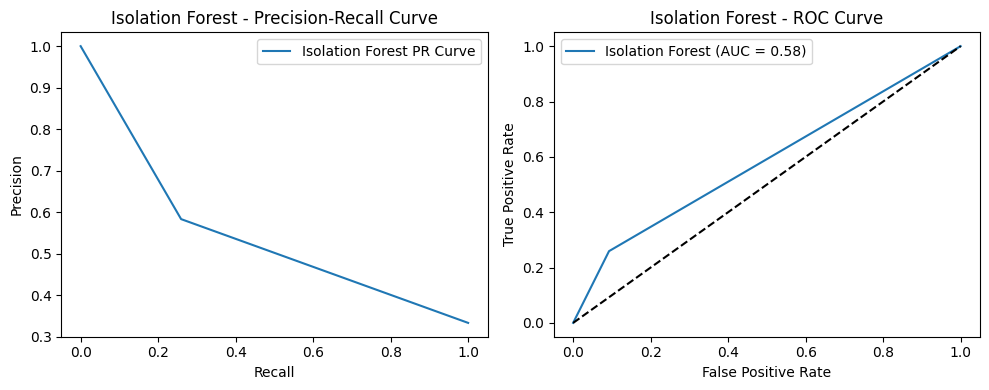

In [42]:
from sklearn.metrics import precision_recall_curve, roc_curve, auc

def plot_pr_roc(true_labels, scores, model_name):
    # Precision-Recall
    precision, recall, _ = precision_recall_curve(true_labels, scores)
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.plot(recall, precision, label=f'{model_name} PR Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'{model_name} - Precision-Recall Curve')
    plt.legend()

    # ROC Curve
    fpr, tpr, _ = roc_curve(true_labels, scores)
    roc_auc = auc(fpr, tpr)
    plt.subplot(1,2,2)
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{model_name} - ROC Curve')
    plt.legend()
    plt.tight_layout()
    plt.show()

# Autoencoder
merged_df = merged_df.merge(ae_df[['timestamp', 'url', 'recon_error']], on=['timestamp', 'url'], how='left')
plot_pr_roc(merged_df['true_ae'], merged_df['recon_error'], 'Autoencoder')

# Isolation Forest (if anomaly_score exists)
if 'anomaly_score' in iso_df.columns:
    merged_df = merged_df.merge(iso_df[['timestamp', 'url', 'anomaly_score']], on=['timestamp', 'url'], how='left')
    plot_pr_roc(merged_df['true_if'], merged_df['anomaly_score'], 'Isolation Forest')

In [45]:
merged_df.rename(columns={
    'is_anomaly_if_y': 'pred_if'
}, inplace=True)

# Now rerun the comparison
both_anomalies = ((merged_df['pred_if'] == 1) & (merged_df['pred_ae'] == 1)).sum()
only_if = ((merged_df['pred_if'] == 1) & (merged_df['pred_ae'] == 0)).sum()
only_ae = ((merged_df['pred_if'] == 0) & (merged_df['pred_ae'] == 1)).sum()

print(f"\n🔍 Anomaly Detection Overlap:")
print(f"• Both models agree: {both_anomalies}")
print(f"• Only Isolation Forest: {only_if}")
print(f"• Only Autoencoder: {only_ae}")


🔍 Anomaly Detection Overlap:
• Both models agree: 138
• Only Isolation Forest: 0
• Only Autoencoder: 14


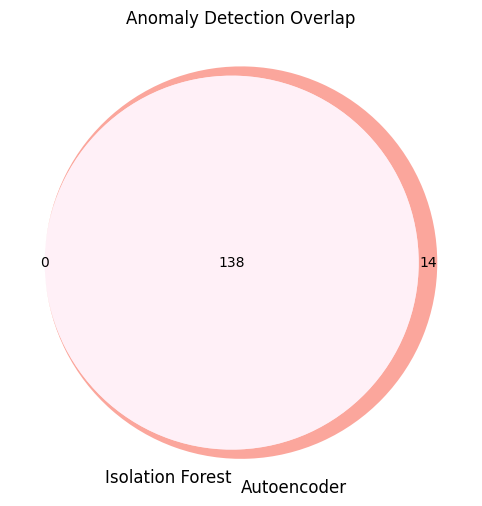

In [47]:
from matplotlib_venn import venn2
import matplotlib.pyplot as plt

# Counts
both_anomalies = ((merged_df['pred_if'] == 1) & (merged_df['pred_ae'] == 1)).sum()
only_if = ((merged_df['pred_if'] == 1) & (merged_df['pred_ae'] == 0)).sum()
only_ae = ((merged_df['pred_if'] == 0) & (merged_df['pred_ae'] == 1)).sum()

# Plot Venn Diagram
plt.figure(figsize=(6,6))
venn2(
    subsets=(only_if, only_ae, both_anomalies),
    set_labels=('Isolation Forest', 'Autoencoder'),
    set_colors=('skyblue', 'salmon'),
    alpha=0.7
)
plt.title("Anomaly Detection Overlap")
plt.show()


In [48]:
merged_df.to_csv('../data/processed/final_merged.csv', index=False)
print("✅ Saved as final_merged.csv")

✅ Saved as final_merged.csv
